In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize,differential_evolution
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import expm
from scipy.integrate import quad_vec

# **Extract Data**

In [ ]:
# Load CSV, skipping first 10 rows and selecting only relevant columns
file_path = "feds200628.csv"  # Ensure correct file path
columns_to_use = ["Date", "BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]

df = pd.read_csv(file_path, skiprows=9, usecols=columns_to_use)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Filter data for the period January 1995 - December 2024
df = df[(df["Date"] >= "1995-01-01") & (df["Date"] <= "2024-12-31")]


# Ensure that if the first trading day has missing data, move to the next available day
def get_first_valid_trading_day(group):
    return group.dropna(subset=["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]).iloc[0]

first_trading_day_params = df.groupby(df["Date"].dt.to_period("M")).apply(get_first_valid_trading_day).reset_index(drop=True)

# Define maturities (in years)
maturities = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30])

def nelson_siegel_svensson(beta0, beta1, beta2, beta3, tau1, tau2, maturities):
    """Calculate NSS yield curve for given maturities"""

    term = maturities  # Time to maturity
    factor1 = (1 - np.exp(-term / tau1)) / (term / tau1)
    factor2 = factor1 - np.exp(-term / tau1)
    factor3 = (1 - np.exp(-term / tau2)) / (term / tau2) - np.exp(-term / tau2)
    return beta0 + beta1 * factor1 + beta2 * factor2 + beta3 * factor3

# Nx360 matrix
monthly_yields = np.zeros(( len(maturities),len(first_trading_day_params)))

# Compute NSS yields for each month
for i, (_, row) in enumerate(first_trading_day_params.iterrows()):
    monthly_yields[:,i] = nelson_siegel_svensson(
        row["BETA0"], row["BETA1"], row["BETA2"], row["BETA3"],
        row["TAU1"], row["TAU2"], maturities
    )/100


# **Kalman filter (independent state factors), loglikelihoods & other maths**

In [ ]:

def AFNS_kalman_filter_independent_PandQ(yields, maturities, kappa,theta,Lambda, sigma, X0,p0,measurement_std,LL):
    # Number of time steps (in months) and maturities
    n_timesteps = yields.shape[1] #360
    n_maturities = len(maturities) #8
    n_factors=Lambda.shape[0] #3

    # 1 month
    dt = 1/12

    # Create arrays for storing results
    # NB not matrix- 1D arrays (1xn_timeteps)
    r_estimates = np.zeros(n_timesteps)
    var_rt_estimates=np.zeros(n_timesteps)
    # 3xT matrix but each column is not a column vector
    # X[:,1] is 1D array of length 3
    X_estimates = np.zeros((n_factors,n_timesteps))
    # (3x3)xT matrix each cov matrix IS a numpy matrix!
    # P[:,:,1] is 3x3 numpy matrix
    p_estimates = np.zeros((n_factors,n_factors,n_timesteps))

    #X0 and p0 are matrices 3x1 and 3x3
    # Set initial values
    r_estimates[0] = X0[0, 0] + X0[1, 0]     # Initial short rate process
    var_rt_estimates[0] = p0[0, 0] + p0[1, 1] + 2*p0[0, 1]
    X_estimates[:,0] = X0.flatten()          # Initial state process
    p_estimates[:,:,0] = p0            # Initial uncertainty

    # B(τ) coefficient
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(τ)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities
    """
    # 3x3 matrix
    A=(np.identity(n_factors)-kappa)*dt
    # 3x1 matrix
    a=kappa@theta*dt

    # Extract diagonal elements of sigma (independent under P)
    sigma_diag = np.diag(np.diag(sigma))

    # Construct Q using only the diagonal elements
    Q = (sigma_diag @ sigma_diag.T) * dt
    """
    a = np.array((np.identity(3)-expm(-kappa * dt))@theta).reshape(3,1)
    A = np.array( expm(-kappa*dt)).reshape(3,3)

    def compute_Q(KP, Sigma, t):
        """
        Compute the Q covariance matrix for a multivariate OU process:
        Q = ∫₀ᵗ e^{-KP s} Σ Σᵀ e^{-KPᵀ s} ds
        """

        def integrand(s):
            matrix_exponential_lambda = expm(-KP * s)
            return matrix_exponential_lambda @ Sigma @ Sigma.T @ matrix_exponential_lambda.T

        # Integrate element-wise
        Q, _ = quad_vec(integrand, 0, t)
        return Q
    sigma_P = np.diag(np.diag(sigma))
    Q = compute_Q(kappa, sigma_P, dt)


    # 8x8 matrix
    R = measurement_std**2 * np.identity(n_maturities)

    # Kalman filter iterations
    for t in range(1, n_timesteps):

        #---------- 1. PREDICTION STEP ----------#
        # 3x1 matrix
        X_predicted = A @ X_estimates[:, t-1].reshape(3,1) + a

        # 3x3 matrix
        p_predicted = A @ p_estimates[:, :, t-1] @ A.T + Q

        #---------- 2. UPDATE STEP ----------#
        # 8x1 matrix
        yields_predicted = h + H @ X_predicted

        # 8x1 matrix
        y_bar = yields[:, t].reshape(n_maturities, 1) - yields_predicted

        # 8x8 matrix
        F = H @ p_predicted @ H.T + R

        # 3x8 matrix
        K = p_predicted @ H.T @ np.linalg.inv(F)

        # Update state estimate
        #remeber each column of X is 1D array of length 3
        X_estimates[:, t] = (X_predicted + K @ y_bar).flatten()
        r_estimates[t] = X_estimates[0, t] + X_estimates[1, t] #scalar + scaler = scalar

        # Update uncertainty estimate
        #3x3 matrix
        term1 = np.identity(n_factors) - K @ H
        #3x3 matrix
        term2 = K @ R @ K.T

        #3x3 matrix
        #remember each double layer of P is 3x3 matrix so no need to flatten
        p_estimates[:, :, t] = term1 @ p_predicted @ term1.T + term2

        #VAR(X+Y)=VAR(X) + VAR(Y) + 2*Cov(X,Y)
        var_rt_estimates[t] = p_estimates[0, 0, t] + p_estimates[1, 1, t] + 2*p_estimates[0, 1, t]

        LL += log_likelihood_step(y_bar, F)

    return r_estimates, var_rt_estimates, X_estimates,LL



def log_likelihood_step(y_bar, F):

    dy = y_bar.shape[0]
    sign, logdet = np.linalg.slogdet(F)
    if sign != 1:
        raise ValueError("Covariance matrix is not positive definite")
    inv_F = np.linalg.inv(F)
    term1 = -0.5 * dy * np.log(2 * np.pi)
    term2 = -0.5 * logdet
    term3 = -0.5 * y_bar.T @ inv_F @ y_bar
    return (term1 + term2 + term3).item()

def negative_log_likelihood(params, yields, maturities, X0, p0, LL0):

    #params is 1D array not matrix

    kappa = params[0:3]
    theta = params[3:6]
    lambda1 = params[6]
    sigma_flat = params[7:10]
    measurement_std = params[-1]

    Kappa=np.diag(kappa)

    Theta=theta.reshape(3,1)
    # Construct Lambda matrix from lambda1
    Lambda = np.array([
        [0.0,      0.0,      0.0],
        [0.0,  lambda1,   -lambda1],
        [0.0,      0.0,   lambda1]
    ])

    # Reconstruct sigma as lower-triangular
    Sigma = np.zeros((3, 3))
    np.fill_diagonal(Sigma, sigma_flat)
    #Sigma[np.tril_indices(3)] = sigma_flat

    # Kalman filter or log-likelihood calc
    _, _, _,neg_LL = AFNS_kalman_filter_independent_PandQ(
        yields, maturities,Kappa,Theta, Lambda, Sigma, X0, p0, measurement_std, LL0
    )

    return -neg_LL

def fisher_gilles_covariance(KP, Sigma):
  """
  Computes the steady-state covariance matrix Σ₀ using the Fisher & Gilles spectral decomposition method.
  """
  # Eigen-decomposition of KP
  d, V = np.linalg.eig(KP)       # d = eigenvalues, V = eigenvectors
  D = np.diag(d)
  V_inv = np.linalg.inv(V)

  S = V_inv @ Sigma @ Sigma.T @ V_inv.T

  # Compute L matrix with entries L_ij = S_ij / (d_i + d_j)
  n = D.shape[0]
  L = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          L[i, j] = S[i, j] / (d[i] + d[j])

  # Transform back to original basis
  Sigma_0 = V @ L @ V.T
  return Sigma_0

# **Optimal independent AFNS model paramters (10) under Q and P**

Estimated Kappa matrix:
[[1.00381377e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.77697921e+00]]
Estimated Theta matrix:
[[ 0.03899184]
 [-0.07476833]
 [-0.00124203]]
Estimated Lambda matrix:
[[ 0.          0.          0.        ]
 [ 0.          0.21428843 -0.21428843]
 [ 0.          0.          0.21428843]]

Estimated sigma matrix:
[[-0.00426364  0.          0.        ]
 [ 0.          0.00772303  0.        ]
 [ 0.          0.          0.00366758]]

Estimated measurement noise: 0.001989

LL: 23129.463731


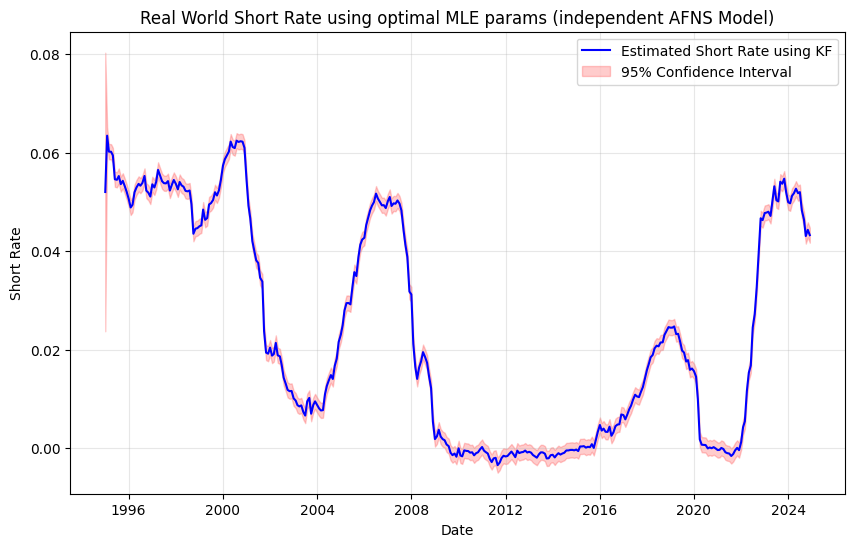

In [ ]:
#set inital values
# Volatility matrix (lower triangular)
sigma = np.array([
    [0.01, 0, 0],
    [0, 0.02, 0],
    [0, 0, 0.02]
])

# Maturities (in years)
maturities = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30]).reshape(-1,1)

#Log likelihood initialisation
LL0=0

initial_kappa = [0.32, 0.17, 0.04]
initial_theta = [0.05, 0.002, 0.01]
initial_lambda = [0.27]
initial_sigma = np.diag(sigma)
initial_measurement_std = [0.002]


# Initial latent state
X0 = np.array(initial_theta).reshape(3, 1)

# Initial uncertainty
"""
needs to be steady state variance, tbc
p0=fisher_gilles_covariance(np.diag(initial_kappa), sigma)

"""
p0 = np.eye(3) * 0.0001

initial_guess = np.concatenate([initial_kappa,initial_theta,initial_lambda, initial_sigma, initial_measurement_std])


bounds = []
bounds += [(1e-5, 10)] * 3        # kappa
bounds += [(1e-5, 0.1)]         # theta 1
bounds += [(-0.1, 0.1)] * 2        # theta
bounds += [(1e-2, 3)]           # lambda
bounds += [(-1, 1)] * 3        # diag sigma
bounds += [(1e-5, 0.01)]           # measurement noise


result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(monthly_yields, maturities, X0, p0,LL0),
    bounds=bounds,
    method='L-BFGS-B'
)
# result = differential_evolution(
#     negative_log_likelihood,
#     bounds,
#     args=(monthly_yields, maturities, X0, p0, LL0),
#     strategy='best1bin',
#     polish=True  # runs L-BFGS-B after finding global minimum
# )
# Unpack result vector

kappa_opt = result.x[0:3]
theta_opt = result.x[3:6]
lambda_opt = result.x[6]
sigma_opt = result.x[7:10]
noise_opt = result.x[-1]

# Reconstruct matrices
Kappa_opt=np.diag(kappa_opt)

Theta_opt=theta_opt.reshape(3,1)

Lambda_opt = np.array([
    [0,       0,       0],
    [0,   lambda_opt,    -lambda_opt],
    [0,       0,    lambda_opt]
])

Sigma_opt = np.zeros((3, 3))
np.fill_diagonal(Sigma_opt, sigma_opt)

# Print nicely
print("Estimated Kappa matrix:")
print(Kappa_opt)
print("Estimated Theta matrix:")
print(Theta_opt)
print("Estimated Lambda matrix:")
print(Lambda_opt)
print("\nEstimated sigma matrix:")
print(Sigma_opt)
print(f"\nEstimated measurement noise: {noise_opt:.6f}")


# Apply Kalman filter
estimated_rates_opt, estimated_variances_opt,estimated_state_factors_opt,LL_opt= AFNS_kalman_filter_independent_PandQ(
  monthly_yields, maturities,Kappa_opt,Theta_opt,Lambda_opt,Sigma_opt, X0,p0,noise_opt,LL0
)
print(f"\nLL: {LL_opt:.6f}")

# Plot results
# Compute standard deviation from variance
std_dev = np.sqrt(estimated_variances_opt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(first_trading_day_params["Date"],estimated_rates_opt, 'b-', label='Estimated Short Rate using KF')

# Add confidence bands (±2 standard deviations)
plt.fill_between(
    first_trading_day_params["Date"],
    estimated_rates_opt - 2 * std_dev,
    estimated_rates_opt + 2 * std_dev,
    color='red', alpha=0.2, label='95% Confidence Interval'
)

plt.title('Real World Short Rate using optimal MLE params (independent AFNS Model)')
plt.xlabel('Date')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def AFNS_yield_curve(X_t, Lambda, sigma, maturities):
  #given a state process and the afns model params under Q we can reconstruct yields at various maturities and compare with historical data
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(tau)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities


    n_steps = X_t.shape[1]
    n_maturities = len(maturities)
    KF_yields = np.zeros((n_maturities,n_steps))

    for t in range(n_steps):
          KF_yields[:, t] = (h + H @ X_t[:,t].reshape(-1,1)).flatten()

    return KF_yields


KF_yields = AFNS_yield_curve(
    estimated_state_factors_opt, Lambda_opt, Sigma_opt, maturities
)


print(f"{'Maturity (Years)':<20}{'MSE':<15}{'R^2':<10}")
print("-" * 45)

for i in range(len(maturities)):
    observed = monthly_yields[i, :]
    estimated = KF_yields[i, :]

    mse = mean_squared_error(observed, estimated)
    r2 = r2_score(observed, estimated)

    print(f"{maturities[i].item():<20.2f}{mse:<15.6f}{r2:<10.4f}")


total_mse = mean_squared_error(monthly_yields.flatten(), KF_yields.flatten())
total_r2 = r2_score(monthly_yields.flatten(), KF_yields.flatten())
# AIC and BIC calculation
num_params = 11  # short rate model has 8 parameters
AIC = 2 * num_params - 2 * LL_opt
BIC = np.log(14*360) * num_params - 2 * LL_opt

print("\n" + "-" * 45)
print(f"{'Total MSE:':<20}{total_mse:.6f}")
print(f"{'Total R^2:':<20}{total_r2:.4f}")
print(f"{'AIC:':<20}{AIC:.2f}")
print(f"{'BIC:':<20}{BIC:.2f}")

Maturity (Years)    MSE            R^2       
---------------------------------------------
0.08                0.000001       0.9972    
0.25                0.000005       0.9899    
0.50                0.000004       0.9920    
0.75                0.000002       0.9953    
1.00                0.000001       0.9969    
1.50                0.000002       0.9963    
2.00                0.000003       0.9932    
3.00                0.000005       0.9862    
5.00                0.000007       0.9793    
7.00                0.000006       0.9785    
10.00               0.000006       0.9792    
15.00               0.000005       0.9803    
20.00               0.000005       0.9800    
30.00               0.000011       0.9461    

---------------------------------------------
Total MSE:          0.000005
Total R^2:          0.9894
AIC:                -46236.93
BIC:                -46165.15


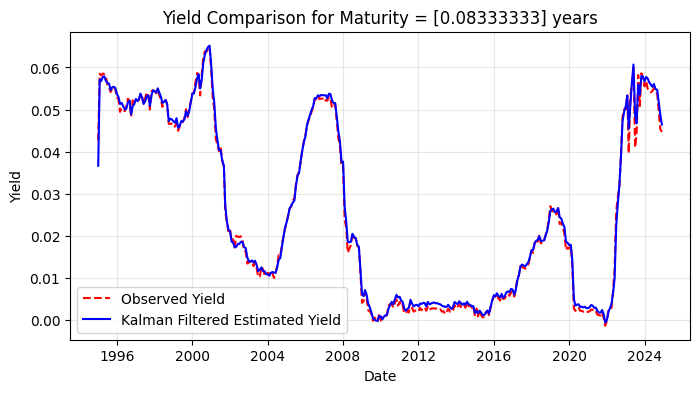

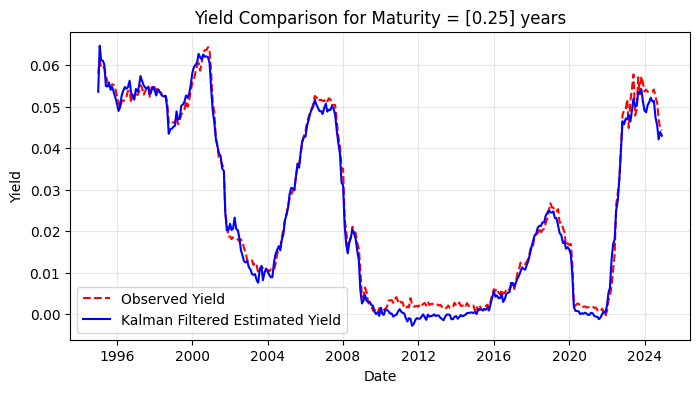

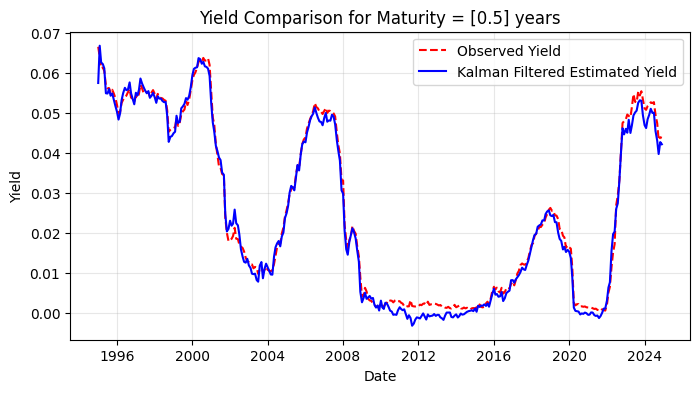

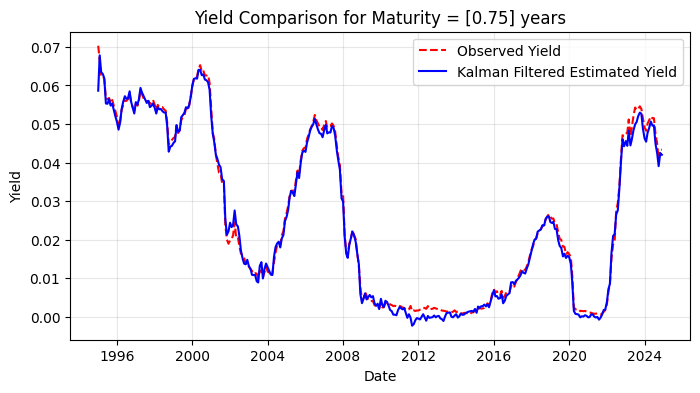

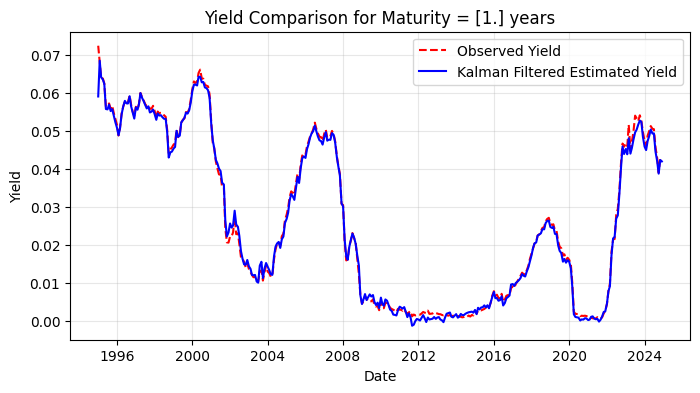

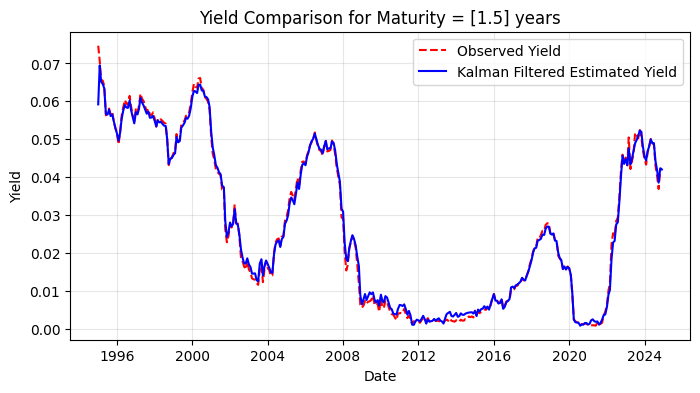

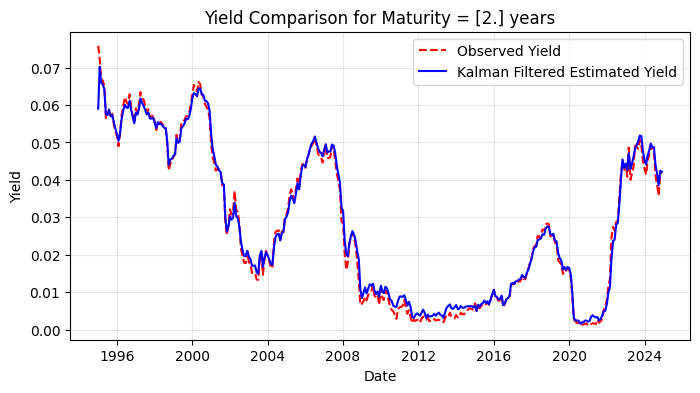

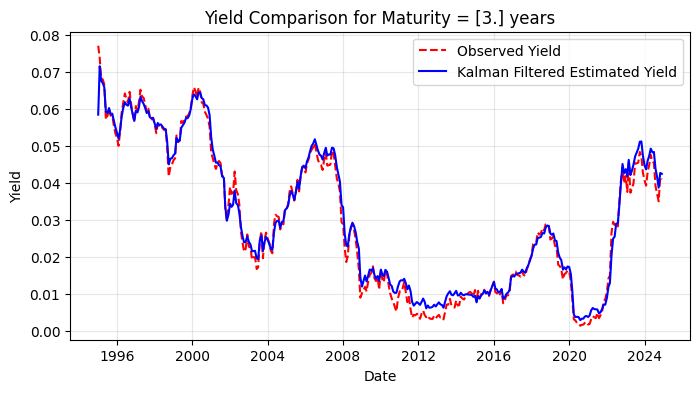

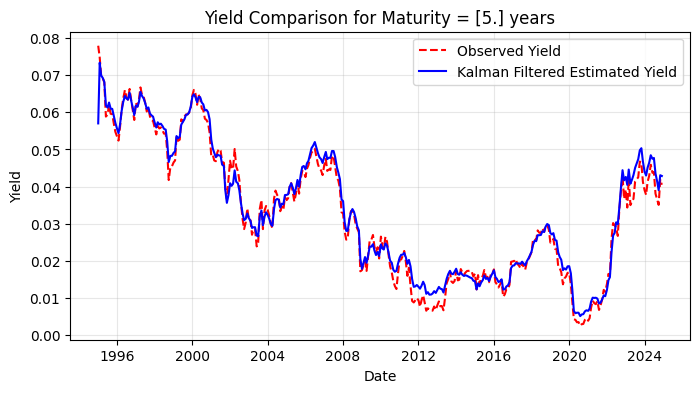

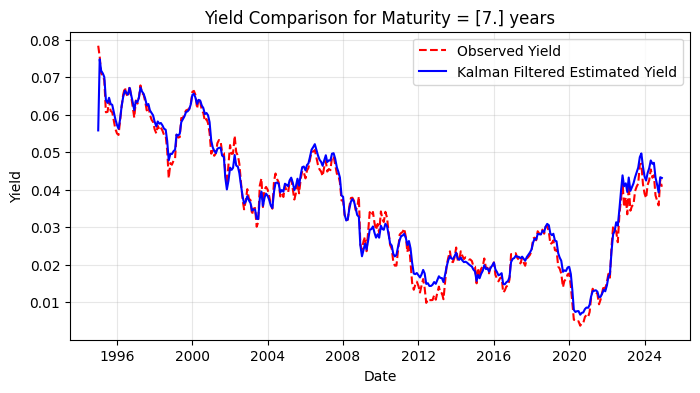

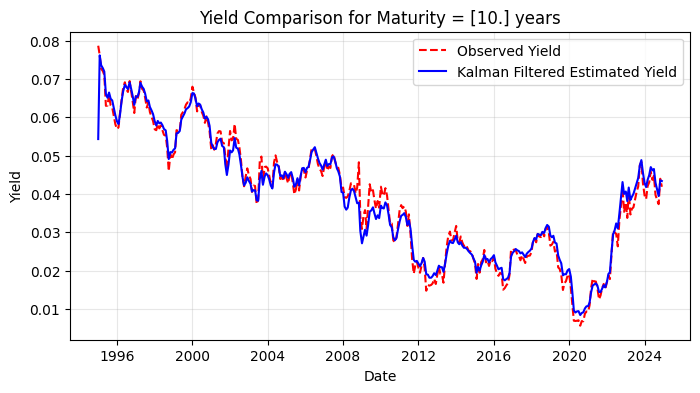

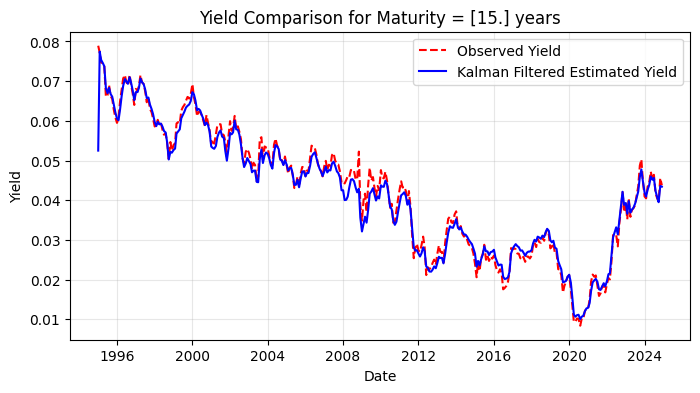

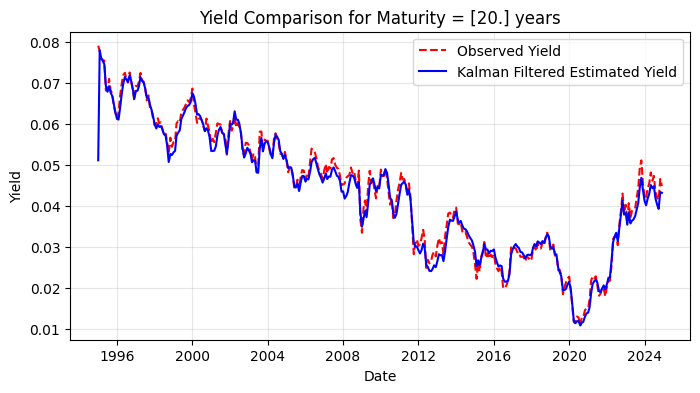

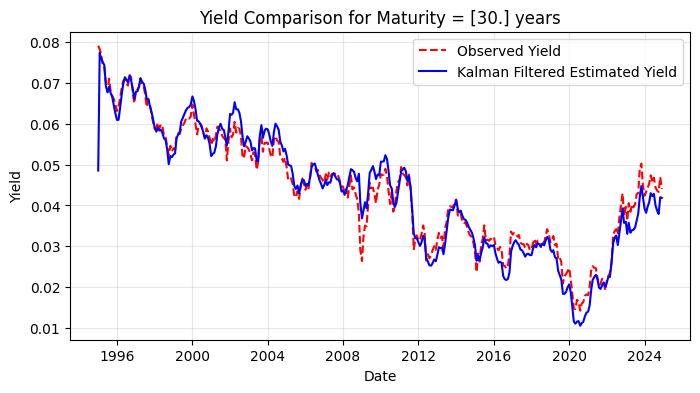

In [ ]:
for i in range(len(maturities)):
    plt.figure(figsize=(8, 4))
    plt.plot(first_trading_day_params["Date"],monthly_yields[i,:], 'r--', label='Observed Yield')
    plt.plot(first_trading_day_params["Date"],KF_yields[i,:], 'b-', label='Kalman Filtered Estimated Yield')
    plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

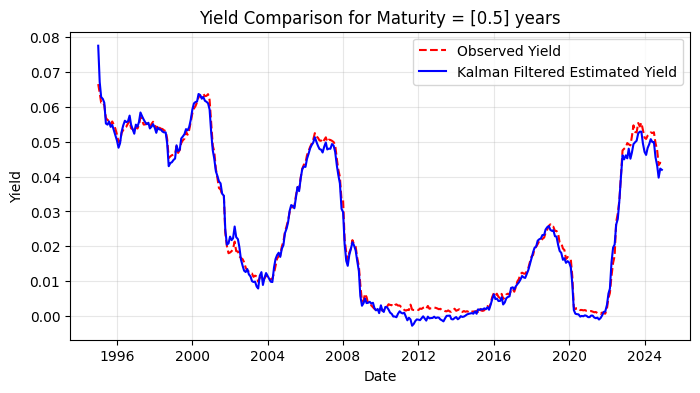

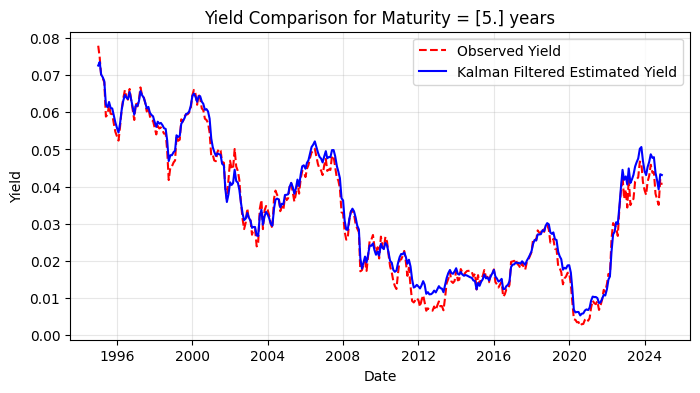

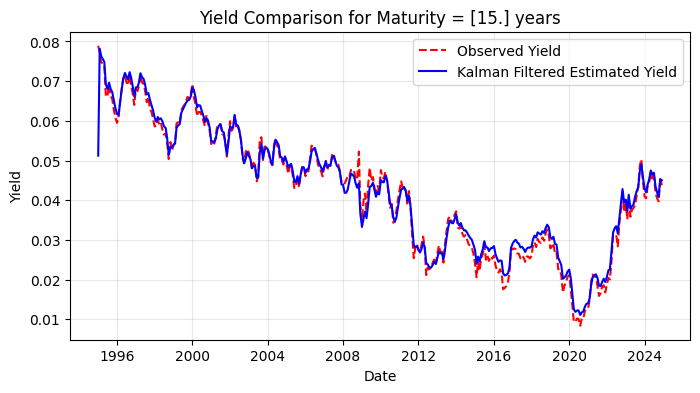

In [ ]:
for i in [2, 8, 11]:
    plt.figure(figsize=(8, 4))
    plt.plot(first_trading_day_params["Date"], monthly_yields[i, :], 'r--', label='Observed Yield')
    plt.plot(first_trading_day_params["Date"], KF_yields[i, :], 'b-', label='Kalman Filtered Estimated Yield')
    plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



# **Kalman filter (correlated state factors), loglikelihoods & other maths**

In [ ]:

def AFNS_kalman_filter_corr_PandQ(yields, maturities, kappa,theta,Lambda, sigma, X0,p0,measurement_std,LL):
    # Number of time steps (in months) and maturities
    n_timesteps = yields.shape[1] #360
    n_maturities = len(maturities) #8
    n_factors=Lambda.shape[0] #3

    # 1 month
    dt = 1/12

    # Create arrays for storing results
    # NB not matrix- 1D arrays (1xn_timeteps)
    r_estimates = np.zeros(n_timesteps)
    var_rt_estimates=np.zeros(n_timesteps)
    # 3xT matrix but each column is not a column vector
    # X[:,1] is 1D array of length 3
    X_estimates = np.zeros((n_factors,n_timesteps))
    # (3x3)xT matrix each cov matrix IS a numpy matrix!
    # P[:,:,1] is 3x3 numpy matrix
    p_estimates = np.zeros((n_factors,n_factors,n_timesteps))

    #X0 and p0 are matrices 3x1 and 3x3
    # Set initial values
    r_estimates[0] = X0[0, 0] + X0[1, 0]     # Initial short rate process
    var_rt_estimates[0] = p0[0, 0] + p0[1, 1] + 2*p0[0, 1]
    X_estimates[:,0] = X0.flatten()          # Initial state process
    p_estimates[:,:,0] = p0            # Initial uncertainty

    # B(τ) coefficient
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(τ)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities


    """
    # 3x3 matrix
    A=(np.identity(n_factors)-kappa)*dt
    # 3x1 matrix
    a=kappa@theta*dt

    #3x3 matrix
    Q = (sigma @ sigma.T) * dt
    """
    a = np.array((np.identity(3)-expm(-kappa * dt))@theta).reshape(3,1)
    A = np.array( expm(-kappa*dt)).reshape(3,3)

    def compute_Q(KP, Sigma, t):
        """
        Compute the Q covariance matrix for a multivariate OU process:
        Q = ∫₀ᵗ e^{-KP s} Σ Σᵀ e^{-KPᵀ s} ds
        """

        def integrand(s):
            matrix_exponential_lambda = expm(-KP * s)
            return matrix_exponential_lambda @ Sigma @ Sigma.T @ matrix_exponential_lambda.T

        # Integrate element-wise
        Q, _ = quad_vec(integrand, 0, t)
        return Q
    Q = compute_Q(kappa, sigma, dt)



    # 8x8 matrix
    R = measurement_std**2 * np.identity(n_maturities)

    # Kalman filter iterations
    for t in range(1, n_timesteps):

        #---------- 1. PREDICTION STEP ----------#
        # 3x1 matrix
        X_predicted = A @ X_estimates[:, t-1].reshape(3,1) + a

        # 3x3 matrix
        p_predicted = A @ p_estimates[:, :, t-1] @ A.T + Q

        #---------- 2. UPDATE STEP ----------#
        # 8x1 matrix
        yields_predicted = h + H @ X_predicted

        # 8x1 matrix
        y_bar = yields[:, t].reshape(n_maturities, 1) - yields_predicted

        # 8x8 matrix
        F = H @ p_predicted @ H.T + R

        # 3x8 matrix
        K = p_predicted @ H.T @ np.linalg.inv(F)

        # Update state estimate
        #remeber each column of X is 1D array of length 3
        X_estimates[:, t] = (X_predicted + K @ y_bar).flatten()
        r_estimates[t] = X_estimates[0, t] + X_estimates[1, t] #scalar + scaler = scalar

        # Update uncertainty estimate
        #3x3 matrix
        term1 = np.identity(n_factors) - K @ H
        #3x3 matrix
        term2 = K @ R @ K.T

        #3x3 matrix
        #remember each double layer of P is 3x3 matrix so no need to flatten
        p_estimates[:, :, t] = term1 @ p_predicted @ term1.T + term2

        #VAR(X+Y)=VAR(X) + VAR(Y) + 2*Cov(X,Y)
        var_rt_estimates[t] = p_estimates[0, 0, t] + p_estimates[1, 1, t] + 2*p_estimates[0, 1, t]

        LL += log_likelihood_step(y_bar, F)

    return r_estimates, var_rt_estimates, X_estimates,LL



def log_likelihood_step(y_bar, F):

    dy = y_bar.shape[0]
    sign, logdet = np.linalg.slogdet(F)
    if sign != 1:
        raise ValueError("Covariance matrix is not positive definite")
    inv_F = np.linalg.inv(F)
    term1 = -0.5 * dy * np.log(2 * np.pi)
    term2 = -0.5 * logdet
    term3 = -0.5 * y_bar.T @ inv_F @ y_bar
    return (term1 + term2 + term3).item()

def negative_log_likelihood(params, yields, maturities, X0, p0, LL0):
    #params is 1D array not matrix

    kappa = params[0:9]
    theta = params[9:12]
    lambda1 = params[12]
    sigma_flat = params[13:19]
    measurement_std = params[-1]

    Kappa=kappa.reshape(3,3)

    Theta=theta.reshape(3,1)
    # Construct Lambda matrix from lambda1
    Lambda = np.array([
        [0.0,      0.0,      0.0],
        [0.0,  lambda1,   -lambda1],
        [0.0,      0.0,   lambda1]
    ])

    # Reconstruct sigma as lower-triangular
    Sigma = np.zeros((3, 3))
    Sigma[np.tril_indices(3)] = sigma_flat

    # Kalman filter or log-likelihood calc
    _, _, _,neg_LL = AFNS_kalman_filter_corr_PandQ(
        yields, maturities,Kappa,Theta, Lambda, Sigma, X0, p0, measurement_std, LL0
    )

    return -neg_LL

def fisher_gilles_covariance(KP, Sigma):
  """
  Computes the steady-state covariance matrix Σ₀ using the Fisher & Gilles spectral decomposition method.
  """
  # Eigen-decomposition of KP
  d, V = np.linalg.eig(KP)       # d = eigenvalues, V = eigenvectors
  D = np.diag(d)
  V_inv = np.linalg.inv(V)

  S = V_inv @ Sigma @ Sigma.T @ V_inv.T

  # Compute L matrix with entries L_ij = S_ij / (d_i + d_j)
  n = D.shape[0]
  L = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          L[i, j] = S[i, j] / (d[i] + d[j])

  # Transform back to original basis
  Sigma_0 = V @ L @ V.T
  return Sigma_0

# **Optimal correlated AFNS model paramters (19) under Q and P**

Estimated Kappa matrix:
[[ 0.00346541 -0.00795382  0.57083975]
 [ 0.20740704  0.10442791 -0.5414352 ]
 [ 0.05068567  0.02319401  0.2680833 ]]
Estimated Theta matrix:
[[ 0.06814588]
 [-0.06436751]
 [-0.00331929]]
Estimated Lambda matrix:
[[ 0.         0.         0.       ]
 [ 0.         0.2079469 -0.2079469]
 [ 0.         0.         0.2079469]]

Estimated sigma matrix:
[[ 4.61941127e-03  0.00000000e+00  0.00000000e+00]
 [-3.91855688e-03  6.80497563e-03  0.00000000e+00]
 [ 1.21348313e-03 -2.40678368e-05  2.89819909e-03]]

Estimated measurement noise: 0.001968

LL: 23197.149382


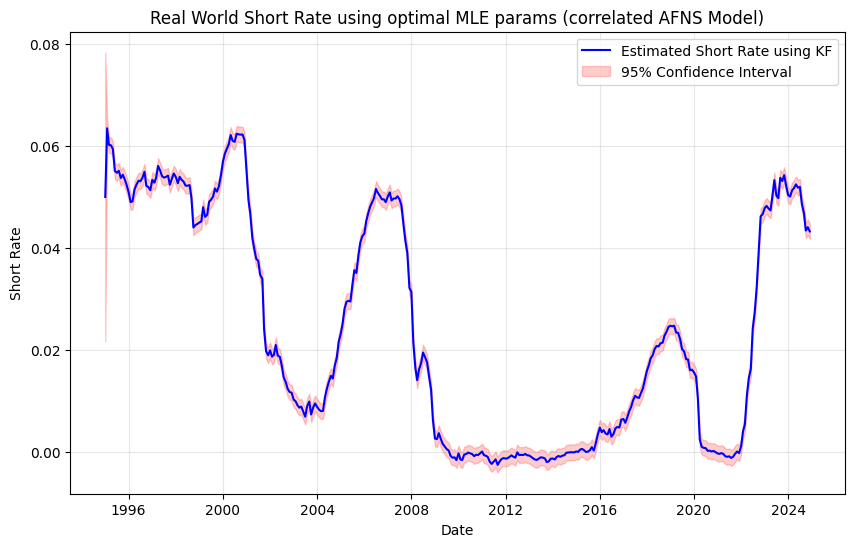

In [ ]:
#set inital values
# Volatility matrix (lower triangular)
sigma = np.array([
    [0.001, 0, 0],
    [0.005, 0.008, 0],
    [0.002, 0.003, 0.007]
])


# Maturities (in years)
maturities = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30]).reshape(-1,1)

#Log likelihood initialisation
LL0=0

initial_kappa = [1.5, 0, 0.2,  0, 0.9, 0.05,  0.1, 0, 0.8]
initial_theta = [0.03, 0.02, 0.05]
initial_lambda = [0.4]
initial_sigma = sigma[np.tril_indices(3)]
initial_measurement_std = [0.002]


# Initial latent state
X0 = np.array(initial_theta).reshape(3, 1)

# Initial uncertainty
"""
needs to be steady state variance, tbc

p0=fisher_gilles_covariance(np.array(initial_kappa).reshape(3,3), sigma)
"""

p0 = np.eye(3) * 0.0001
initial_guess = np.concatenate([initial_kappa,initial_theta,initial_lambda, initial_sigma, initial_measurement_std])


bounds = []
bounds += [(-10, 10)] * 9        # kappa
bounds += [(-0.1, 0.1)] * 3        # theta
bounds += [(1e-2, 5)]           # lambda
bounds += [(-1, 1)] * 6        # lower-triangle sigma
bounds += [(1e-5, 0.01)]           # measurement noise


result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(monthly_yields, maturities, X0, p0,LL0),
    bounds=bounds,
    method='L-BFGS-B'
)
# Unpack result vector

kappa_opt = result.x[0:9]
theta_opt = result.x[9:12]
lambda_opt = result.x[12]
sigma_opt = result.x[13:19]
noise_opt = result.x[-1]

# Reconstruct matrices
Kappa_opt=kappa_opt.reshape(3,3)

Theta_opt=theta_opt.reshape(3,1)

Lambda_opt = np.array([
    [0,       0,       0],
    [0,   lambda_opt,    -lambda_opt],
    [0,       0,    lambda_opt]
])

Sigma_opt = np.zeros((3, 3))
Sigma_opt[np.tril_indices(3)] = sigma_opt

# Print nicely
print("Estimated Kappa matrix:")
print(Kappa_opt)
print("Estimated Theta matrix:")
print(Theta_opt)
print("Estimated Lambda matrix:")
print(Lambda_opt)
print("\nEstimated sigma matrix:")
print(Sigma_opt)
print(f"\nEstimated measurement noise: {noise_opt:.6f}")


# Apply Kalman filter
estimated_rates_opt, estimated_variances_opt,estimated_state_factors_opt,LL_opt= AFNS_kalman_filter_corr_PandQ(
  monthly_yields, maturities,Kappa_opt,Theta_opt,Lambda_opt,Sigma_opt, X0,p0,noise_opt,LL0
)

print(f"\nLL: {LL_opt:.6f}")

# Plot results
# Compute standard deviation from variance
std_dev = np.sqrt(estimated_variances_opt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(first_trading_day_params["Date"],estimated_rates_opt, 'b-', label='Estimated Short Rate using KF')

# Add confidence bands (±2 standard deviations)
plt.fill_between(
    first_trading_day_params["Date"],
    estimated_rates_opt - 2 * std_dev,
    estimated_rates_opt + 2 * std_dev,
    color='red', alpha=0.2, label='95% Confidence Interval'
)

plt.title('Real World Short Rate using optimal MLE params (correlated AFNS Model)')
plt.xlabel('Date')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def AFNS_yield_curve(X_t, Lambda, sigma, maturities):
  #given a state process and the afns model params under Q we can reconstruct yields at various maturities and compare with historical data
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(tau)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities


    n_steps = X_t.shape[1]
    n_maturities = len(maturities)
    KF_yields = np.zeros((n_maturities,n_steps))

    for t in range(n_steps):
          KF_yields[:, t] = (h + H @ X_t[:,t].reshape(-1,1)).flatten()

    return KF_yields


KF_yields = AFNS_yield_curve(
    estimated_state_factors_opt, Lambda_opt, Sigma_opt, maturities
)


print(f"{'Maturity (Years)':<20}{'MSE':<15}{'R^2':<10}")
print("-" * 45)

for i in range(len(maturities)):
    observed = monthly_yields[i, :]
    estimated = KF_yields[i, :]

    mse = mean_squared_error(observed, estimated)
    r2 = r2_score(observed, estimated)

    print(f"{maturities[i].item():<20.2f}{mse:<15.6f}{r2:<10.4f}")

total_mse = mean_squared_error(monthly_yields.flatten(), KF_yields.flatten())
total_r2 = r2_score(monthly_yields.flatten(), KF_yields.flatten())
# AIC and BIC calculation
num_params = 20  # short rate model has 8 parameters
AIC = 2 * num_params - 2 * LL_opt
BIC = np.log(14*360) * num_params - 2 * LL_opt

print("\n" + "-" * 45)
print(f"{'Total MSE:':<20}{total_mse:.6f}")
print(f"{'Total R^2:':<20}{total_r2:.4f}")
print(f"{'AIC:':<20}{AIC:.2f}")
print(f"{'BIC:':<20}{BIC:.2f}")

Maturity (Years)    MSE            R^2       
---------------------------------------------
0.08                0.000014       0.9700    
0.25                0.000004       0.9910    
0.50                0.000004       0.9921    
0.75                0.000002       0.9953    
1.00                0.000001       0.9971    
1.50                0.000001       0.9971    
2.00                0.000002       0.9947    
3.00                0.000004       0.9889    
5.00                0.000006       0.9832    
7.00                0.000005       0.9825    
10.00               0.000005       0.9823    
15.00               0.000005       0.9812    
20.00               0.000005       0.9775    
30.00               0.000014       0.9329    

---------------------------------------------
Total MSE:          0.000005
Total R^2:          0.9877
AIC:                -46354.30
BIC:                -46223.80


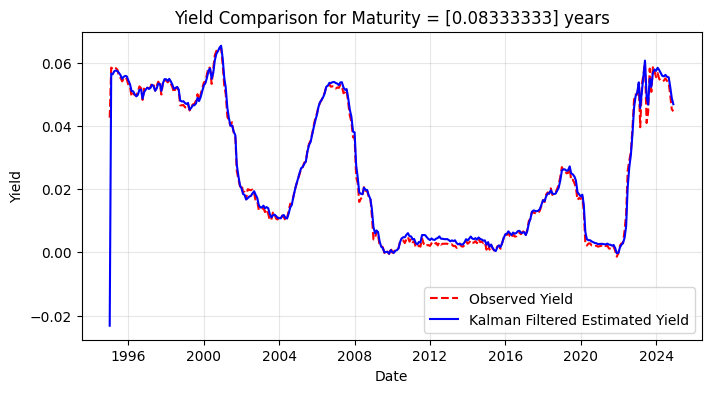

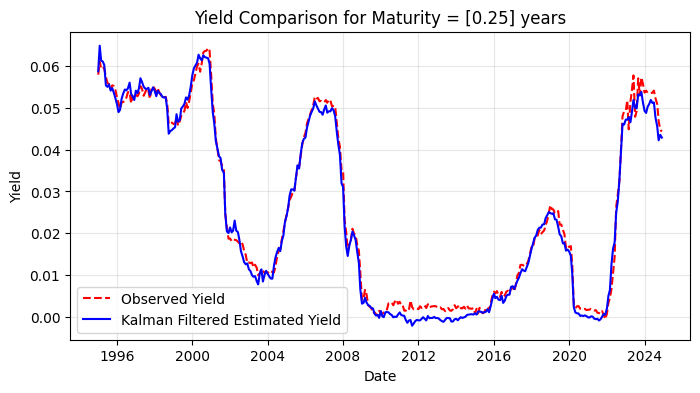

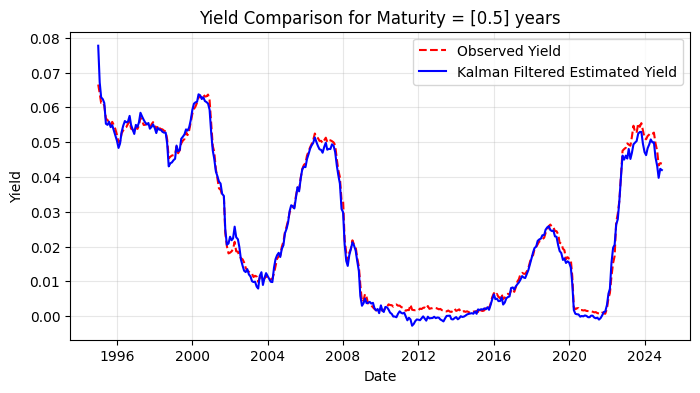

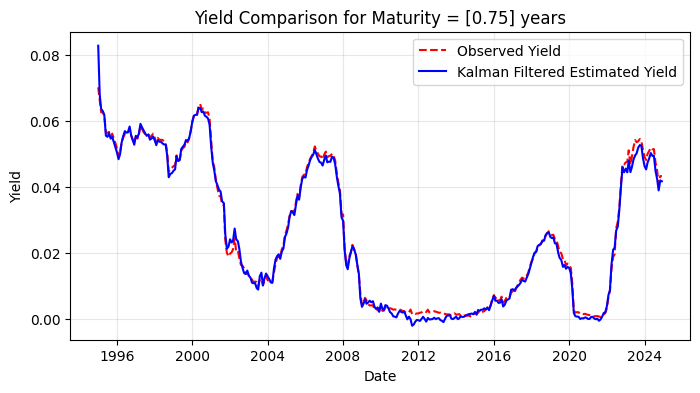

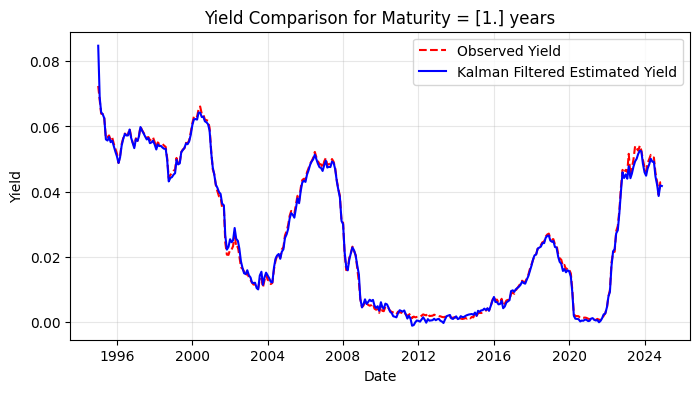

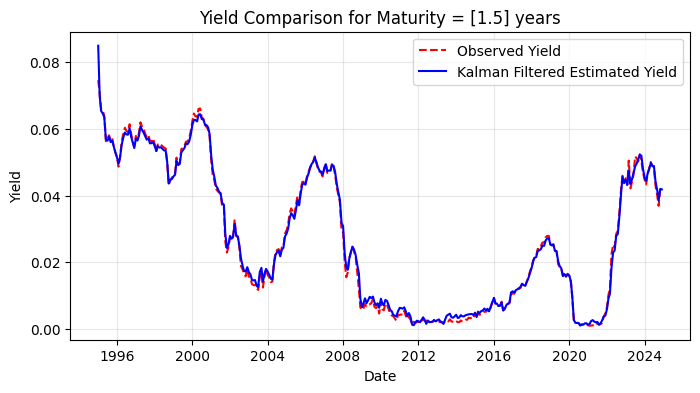

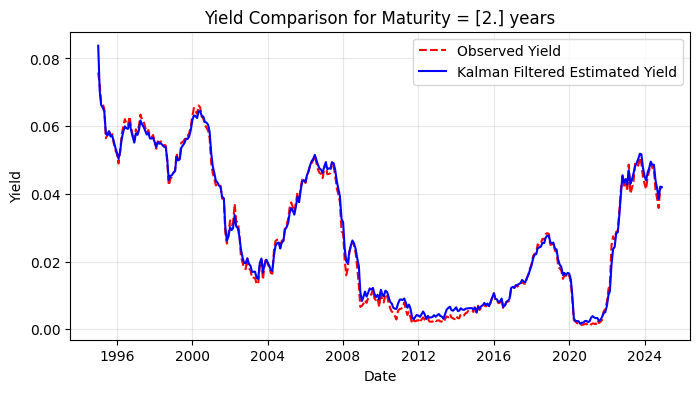

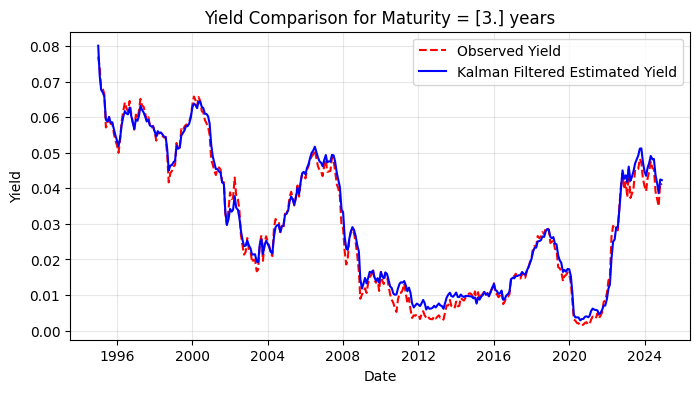

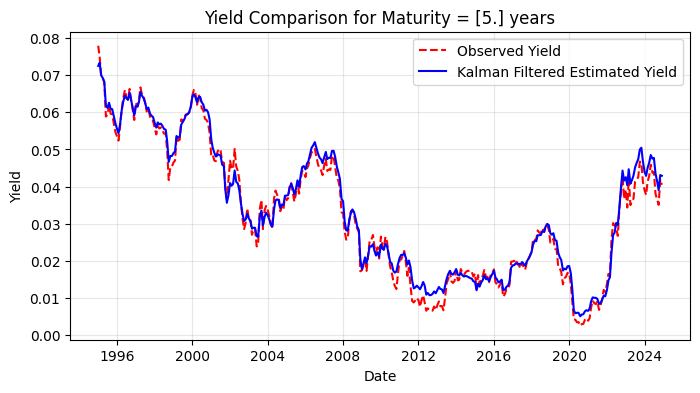

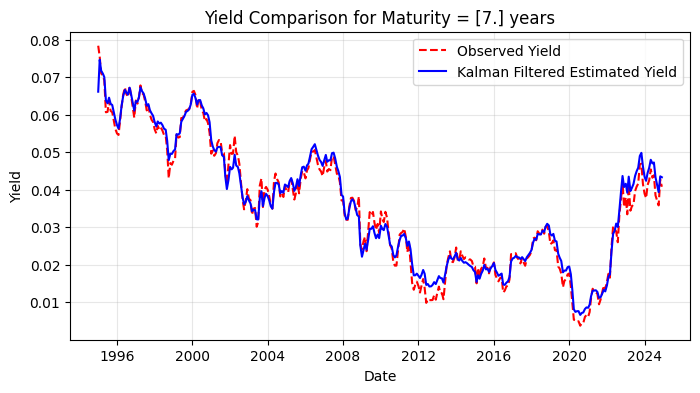

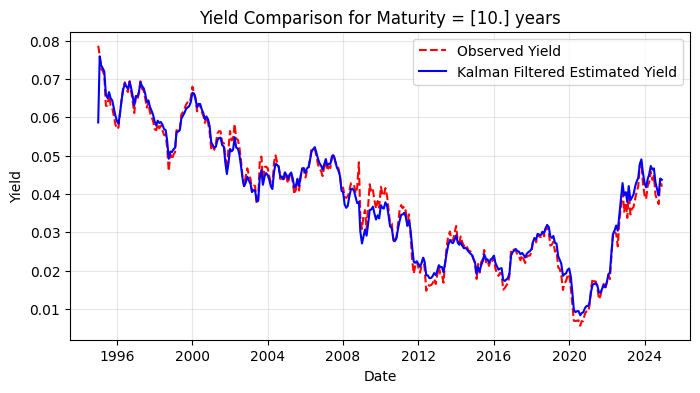

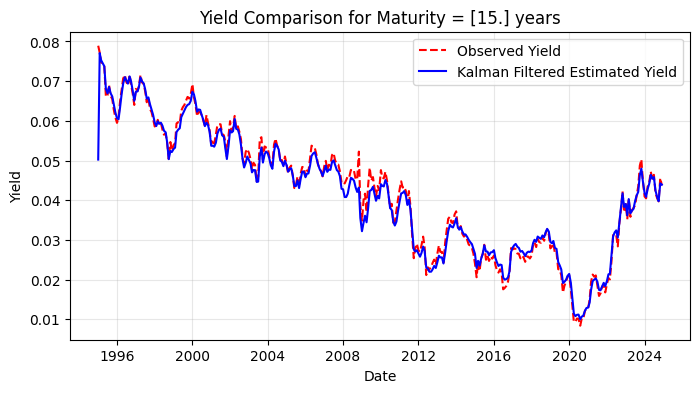

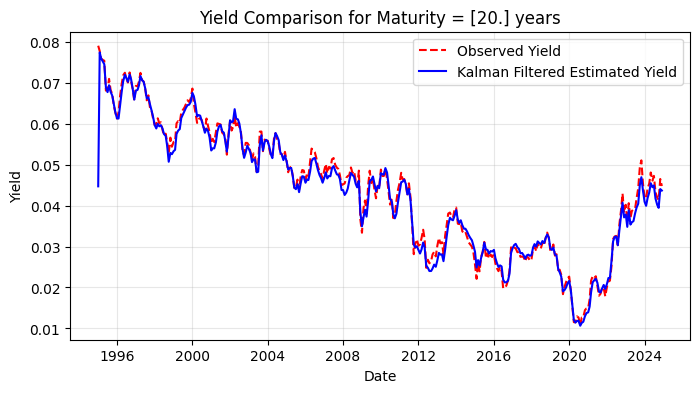

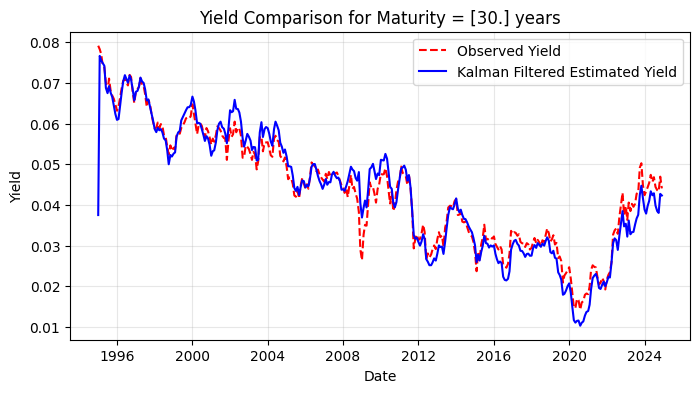

In [ ]:
for i in range(len(maturities)):
    plt.figure(figsize=(8, 4))
    plt.plot(first_trading_day_params["Date"],monthly_yields[i,:], 'r--', label='Observed Yield')
    plt.plot(first_trading_day_params["Date"],KF_yields[i,:], 'b-', label='Kalman Filtered Estimated Yield')
    plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()



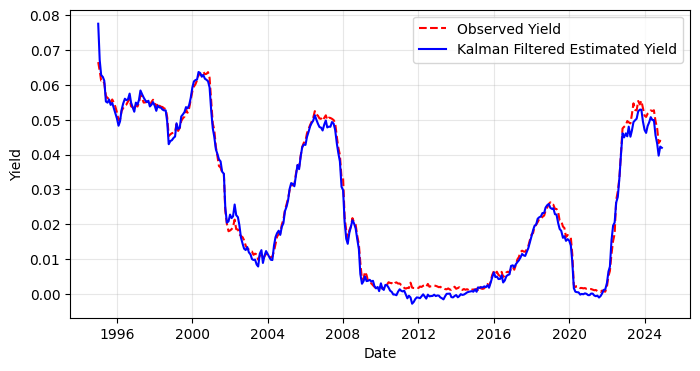

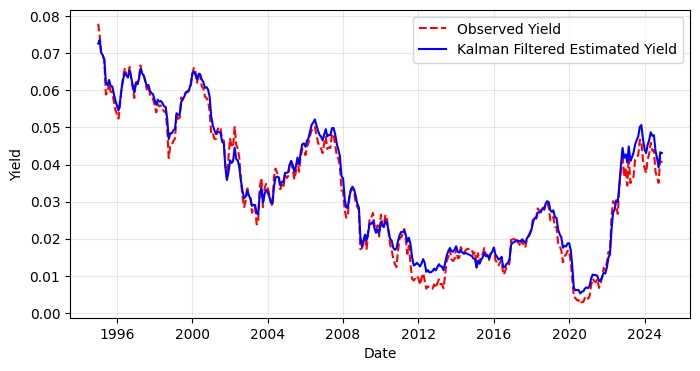

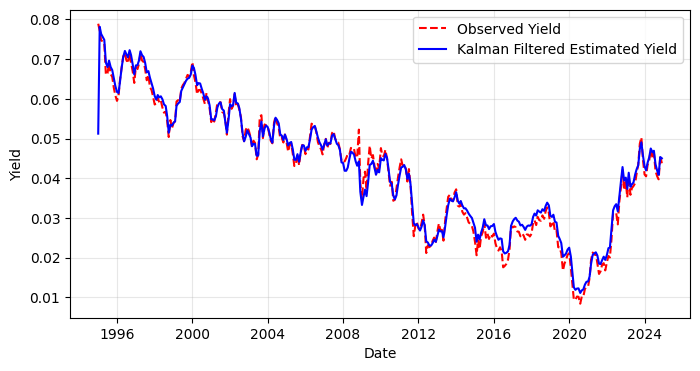

In [ ]:
for i in [2, 8, 11]:
    plt.figure(figsize=(8, 4))
    plt.plot(first_trading_day_params["Date"], monthly_yields[i, :], 'r--', label='Observed Yield')
    plt.plot(first_trading_day_params["Date"], KF_yields[i, :], 'b-', label='Kalman Filtered Estimated Yield')
    #plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()